In [1]:
import os

from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_io as tfio

from tensorflow.keras import layers, models, backend
from tensorflow.keras.layers.experimental import preprocessing

from sklearn.metrics import confusion_matrix, roc_curve, classification_report

## Hyperparameter

In [2]:
LEARNING_RATE = 1e-3
EPOCHS = 100
LR_PATIENCE = int(EPOCHS/4)
BATCH_SIZE = 32
WIDTH = 16000
STRIDE = 4000
RATE = 16000

## Explore the data

In [3]:
esc50_csv = '../data/ESC-50-master/meta/esc50.csv'
data_path = '../data/ESC-50-master/audio/'

df = pd.read_csv(esc50_csv)
df.head()

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


In [4]:
map_class_to_id = {'car_horn':1,'siren':1}

class_id = df['category'].apply(lambda name: map_class_to_id[name] if name in map_class_to_id.keys() else 0)
df = df.assign(target=class_id)

full_path = df['filename'].apply(lambda row: os.path.join(data_path, row))
df = df.assign(filename=full_path)

df.head(10)

,filename,fold,target,category,esc10,src_file,take
0,../data/ESC-50-master/audio/1-100032-A-0.wav,1,0,dog,True,100032,A
1,../data/ESC-50-master/audio/1-100038-A-14.wav,1,0,chirping_birds,False,100038,A
2,../data/ESC-50-master/audio/1-100210-A-36.wav,1,0,vacuum_cleaner,False,100210,A
3,../data/ESC-50-master/audio/1-100210-B-36.wav,1,0,vacuum_cleaner,False,100210,B
4,../data/ESC-50-master/audio/1-101296-A-19.wav,1,0,thunderstorm,False,101296,A
5,../data/ESC-50-master/audio/1-101296-B-19.wav,1,0,thunderstorm,False,101296,B
6,../data/ESC-50-master/audio/1-101336-A-30.wav,1,0,door_wood_knock,False,101336,A
7,../data/ESC-50-master/audio/1-101404-A-34.wav,1,0,can_opening,False,101404,A
8,../data/ESC-50-master/audio/1-103298-A-9.wav,1,0,crow,False,103298,A
9,../data/ESC-50-master/audio/1-103995-A-30.wav,1,0,door_wood_knock,False,103995,A


In [5]:
def load_wav_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=RATE)
    wav = tf.expand_dims(wav, axis=1)
#     wav = wav[:8000]
    return wav

(80000,)


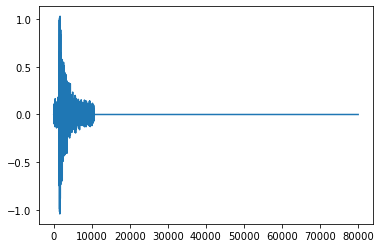

In [6]:
testing_wav_data = tf.squeeze(load_wav_16k_mono(df[df['target']==1].iloc[0,0]), axis=1)
print(testing_wav_data.shape)

_ = plt.plot(testing_wav_data)

display.Audio(testing_wav_data, rate=RATE)

## Hyperparameters

## Datasets

In [7]:
filenames = df['filename']
targets = df['target']
folds = df['fold']

In [8]:
def load_wav_for_map(filename, target, fold):
    return load_wav_16k_mono(filename), target, fold
    
def split_wav(filename, width, stride):
    return tf.map_fn(fn=lambda t: filename[t * stride:t * stride + width], elems=tf.range((tf.shape(filename)[0] - width) // stride), fn_output_signature=tf.float32)

def wav_not_empty(filename, target):
    return tf.experimental.numpy.any(filename)

def split_wav_for_flat_map(filename, target, fold):
    wavs = split_wav(filename, width=WIDTH, stride=STRIDE)
    targets = tf.repeat(target, tf.shape(wavs)[0])
    folds = tf.repeat(fold, tf.shape(wavs)[0])

    return tf.data.Dataset.from_tensor_slices((wavs, targets, folds))

In [9]:
main_ds = tf.data.Dataset.from_tensor_slices((filenames, targets, folds))
main_ds = main_ds.map(load_wav_for_map)

split_wav_ds = main_ds.flat_map(split_wav_for_flat_map)
split_wav_ds = split_wav_ds.filter(lambda filename, target, fold: wav_not_empty(filename, target))

In [10]:
positive = len(list(split_wav_ds.filter(lambda filename, target, fold: target == 1).as_numpy_iterator()))
negative = len(list(split_wav_ds.filter(lambda filename, target, fold: target == 0).as_numpy_iterator()))
total = negative + positive
print(f'Examples:\n    Total: {total}\n    Positive: {positive} ({100 * positive / total:.2f}% of total)\n')

Examples:
    Total: 29809
    Positive: 1160 (3.89% of total)



In [11]:
weight_for_0 = (1 / negative) * (total / 2.0)
weight_for_1 = (1 / positive) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print(f'Weight for class 0: {weight_for_0:.2f}')
print(f'Weight for class 1: {weight_for_1:.2f}')

Weight for class 0: 0.52
Weight for class 1: 12.85


In [12]:
cached_ds = split_wav_ds.cache()
train_ds = cached_ds.filter(lambda filename, target, fold: fold > 2)
val_ds = cached_ds.filter(lambda filename, target, fold: fold == 2)
test_ds = cached_ds.filter(lambda filename, target, fold: fold == 1)

remove_fold_column = lambda filenames, label, fold: (filenames, label)

train_ds = train_ds.map(remove_fold_column)
val_ds = val_ds.map(remove_fold_column)
test_ds = test_ds.map(remove_fold_column)

train_ds = train_ds.cache().shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

## Model

In [13]:
samples = train_ds.take(1).get_single_element()[0].shape
samples

TensorShape([32, 16000, 1])

In [14]:
def create_model(input_shape):
    model = models.Sequential([
        layers.Input(shape=(input_shape[1], 1)),
        layers.Conv1D(8, 16, padding='valid', activation='relu', strides=1),
        layers.MaxPooling1D(2),
        layers.Conv1D(8, 16, padding='valid', activation='relu', strides=1),
        layers.MaxPooling1D(2),
        layers.Conv1D(16, 8, padding='valid', activation='relu', strides=1),
        layers.MaxPooling1D(2),
        layers.Conv1D(16, 8, padding='valid', activation='relu', strides=1),
        layers.MaxPooling1D(2),
        layers.Conv1D(32, 4, padding='valid', activation='relu', strides=1),
        layers.MaxPooling1D(2),
        layers.Conv1D(32, 4, padding='valid', activation='relu', strides=1),
        layers.MaxPooling1D(2),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.SGD(learning_rate=LEARNING_RATE),
              metrics=[tf.keras.metrics.TruePositives(name='True Positives'),
                       tf.keras.metrics.FalsePositives(name='False Positives'),
                       tf.keras.metrics.TrueNegatives(name='True Negatives'),
                       tf.keras.metrics.FalseNegatives(name='False Negatives'), 
                       tf.keras.metrics.BinaryAccuracy(name='Accuracy'),
                       tf.keras.metrics.Precision(name='Precision'),
                       tf.keras.metrics.Recall(name='Recall'),
                       tf.keras.metrics.AUC(name='Precision Recall Curve', curve='PR'),
                      ])
    return model

In [15]:
model = create_model(samples)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 15985, 8)          136       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 7992, 8)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 7977, 8)           1032      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 3988, 8)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 3981, 16)          1040      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 1990, 16)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1983, 16)          2

## Training

In [16]:
checkpoint_filepath = './trained_models/'

history = model.fit(
    train_ds, 
    validation_data=val_ds,
    epochs=EPOCHS,
    class_weight=class_weight,
    callbacks=[tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=LR_PATIENCE, verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0),
               tf.keras.callbacks.ModelCheckpoint(checkpoint_filepath + '{epoch:02d}-{val_loss:.2f}.ckpt', monitor='val_loss', verbose=0, save_best_only=True, 
                                                  save_weights_only=True, mode='auto', save_freq='epoch', options=None)]
)


Epoch 1/100
559/559 [==============================] - 34s 38ms/step - loss: 0.6938 - True Positives: 350.0000 - False Positives: 7280.0000 - True Negatives: 9900.0000 - False Negatives: 349.0000 - Accuracy: 0.5733 - Precision: 0.0459 - Recall: 0.5007 - Precision Recall Curve: 0.0490 - val_loss: 0.6780 - val_True Positives: 44.0000 - val_False Positives: 30.0000 - val_True Negatives: 5717.0000 - val_False Negatives: 201.0000 - val_Accuracy: 0.9614 - val_Precision: 0.5946 - val_Recall: 0.1796 - val_Precision Recall Curve: 0.2189
Epoch 2/100
559/559 [==============================] - 19s 34ms/step - loss: 0.6900 - True Positives: 306.0000 - False Positives: 4711.0000 - True Negatives: 12469.0000 - False Negatives: 393.0000 - Accuracy: 0.7145 - Precision: 0.0610 - Recall: 0.4378 - Precision Recall Curve: 0.0601 - val_loss: 0.6511 - val_True Positives: 61.0000 - val_False Positives: 50.0000 - val_True Negatives: 5697.0000 - val_False Negatives: 184.0000 - val_Accuracy: 0.9609 - val_Precisi

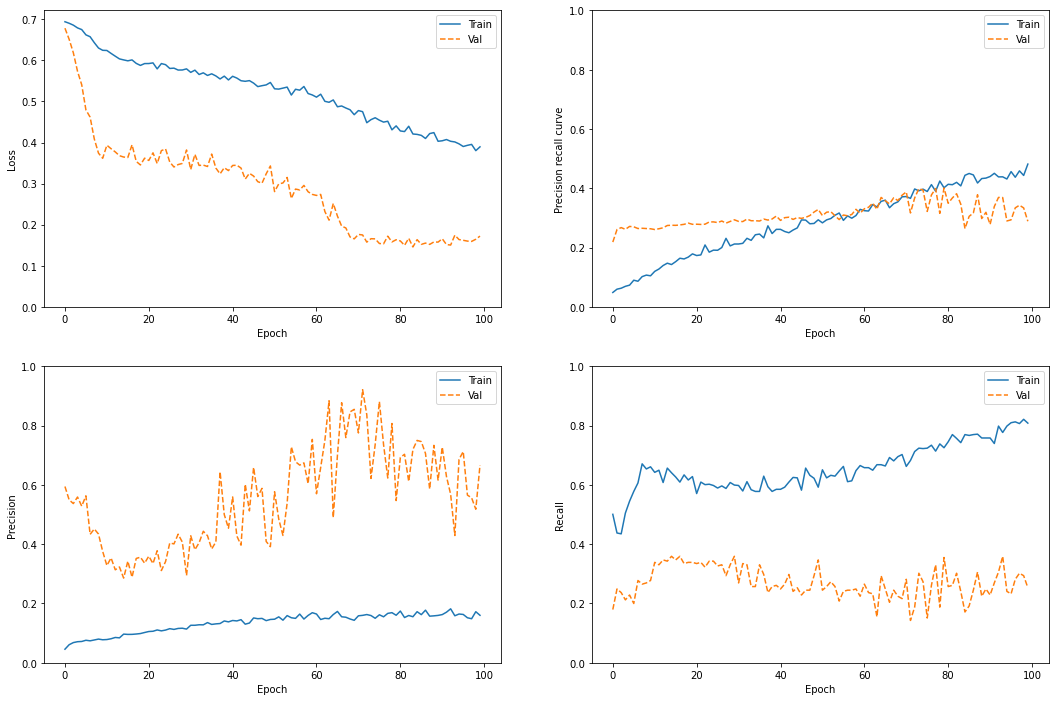

In [17]:
metrics = ['loss', 'Precision Recall Curve', 'Precision', 'Recall']
plt.figure(figsize=(18,12))
for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
        plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
        plt.ylim([0.8,1])
    else:
        plt.ylim([0,1])
    plt.legend()

## Testing

In [18]:
latest = tf.train.latest_checkpoint(checkpoint_filepath)
model = create_model(samples)
model.load_weights(latest)
results = model.evaluate(test_ds)
predictions = model.predict(test_ds)
labels = np.concatenate([out[1].numpy() for out in test_ds]).reshape(-1,1)

186/186 [==============================] - 4s 16ms/step - loss: 0.1613 - True Positives: 39.0000 - False Positives: 24.0000 - True Negatives: 5698.0000 - False Negatives: 177.0000 - Accuracy: 0.9662 - Precision: 0.6190 - Recall: 0.1806 - Precision Recall Curve: 0.2571


In [19]:
for name, value in zip(model.metrics_names, results):
    print(f'{name}: {value:.2f}')

loss: 0.16
True Positives: 39.00
False Positives: 24.00
True Negatives: 5698.00
False Negatives: 177.00
Accuracy: 0.97
Precision: 0.62
Recall: 0.18
Precision Recall Curve: 0.26


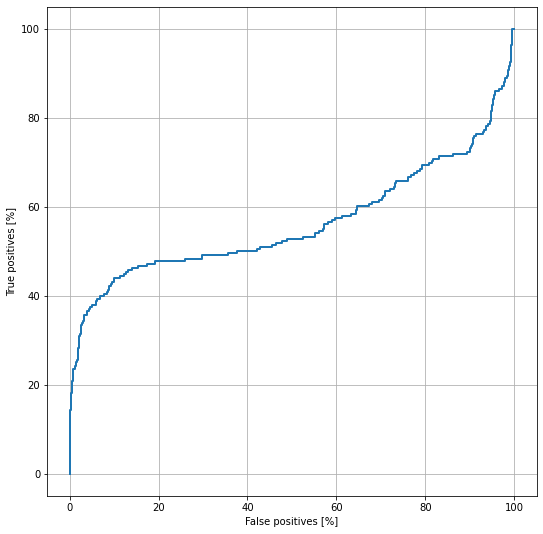

In [20]:
fp, tp, _ = roc_curve(labels, predictions)
plt.figure(figsize=(12,9))
plt.plot(100*fp, 100*tp, label=name, linewidth=2)
plt.xlabel('False positives [%]')
plt.ylabel('True positives [%]')
plt.grid(True)
ax = plt.gca()
ax.set_aspect('equal')

Text(0.5, 24.0, 'Predicted label')

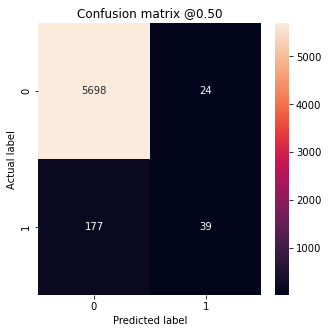

In [21]:
probability = 0.5
cm = confusion_matrix(labels, predictions > probability)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title(f'Confusion matrix @{probability:.2f}')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [22]:
# Convert Keras model to a tflite model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

open(checkpoint_filepath + latest.split('/')[-1] + '.tflite', 'wb').write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\davis\AppData\Local\Temp\tmpmptrqgje\assets


533472